# Data Eng 300 Homework 3

#### Jonathan Wu

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
!curl https://raw.githubusercontent.com/mosesyhc/de300-2025sp-class/refs/heads/main/agnews_clean.csv -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33.2M  100 33.2M    0     0  8527k      0  0:00:03  0:00:03 --:--:-- 8526k


In [64]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .master("local[*]")
         .appName("AG news")
         .getOrCreate()
        )

agnews = spark.read.csv("agnews_clean.csv", inferSchema=True, header=True)

# turning the second column from a string to an array
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StringType
agnews = agnews.withColumn('filtered', F.from_json('filtered', ArrayType(StringType())))

In [4]:
# each row contains the document id and a list of filtered words
agnews.show(5, truncate=30)

+---+------------------------------+
|_c0|                      filtered|
+---+------------------------------+
|  0|[wall, st, bears, claw, bac...|
|  1|[carlyle, looks, toward, co...|
|  2|[oil, economy, cloud, stock...|
|  3|[iraq, halts, oil, exports,...|
|  4|[oil, prices, soar, time, r...|
+---+------------------------------+
only showing top 5 rows



In [101]:
# We find the number of documents in agnews (used in idf calculation)
D = agnews.count()
D

127600

In [80]:
from pyspark.sql.functions import col
# This is just to look at what we are working with, this splits each word out of the document
words_df = agnews.select("_c0",
    # Explode each word out
    F.explode(col("filtered")).alias("word")
).select("_c0",
    # Make all words lowercase (so we ensure no capital letters)
    F.lower(col("word")).alias("word")
)

In [81]:
words_df.show(5)

+---+-----+
|_c0| word|
+---+-----+
|  0| wall|
|  0|   st|
|  0|bears|
|  0| claw|
|  0| back|
+---+-----+
only showing top 5 rows



In [92]:
def get_tf(df):
  # This is the same as two cells above
  words_df = agnews.select("_c0", F.explode(col("filtered")).alias("word")
  ).select("_c0", F.lower(col("word")).alias("word")
  )
  # Find the number of times a term appears in the document (segregated by document)
  terms = words_df.groupBy("_c0", "word").agg(F.count("*").alias("term_count"))
  # Find the number of words in each document
  total_terms = df.select("_c0", F.size("filtered").alias("total_words"))
  # Find the term frequency
  tf_df = terms.join(total_terms, on="_c0", how="inner").withColumn(
    "tf", col("term_count") / col("total_words")
  )
  return tf_df

In [93]:
tf_df = get_tf(agnews)
tf_df.show(5)

+----+---------+----------+-----------+--------------------+
| _c0|     word|term_count|total_words|                  tf|
+----+---------+----------+-----------+--------------------+
| 833|      hit|         1|         13| 0.07692307692307693|
|1088|following|         1|         18| 0.05555555555555555|
|1959|      ups|         2|         29| 0.06896551724137931|
|1959|    block|         1|         29|0.034482758620689655|
|6397|   friday|         1|         27|0.037037037037037035|
+----+---------+----------+-----------+--------------------+
only showing top 5 rows



In [94]:
def get_idf(df):
  # Same words_df as get_tf
  words_df = agnews.select("_c0", F.explode(col("filtered")).alias("word")
  ).select("_c0", F.lower(col("word")).alias("word")
  )
  # Find the number of documents containing a word t
  df_df = words_df.dropDuplicates(["_c0", "word"]).groupBy("word").agg(
      count("*").alias("df")
  )
  # Calculate idf
  idf_df = df_df.withColumn(
      "idf", when(col("df") > 0, F.log(D / col("df"))).otherwise(0)
  )
  return idf_df

In [95]:
idf_df = get_idf(agnews)
idf_df.show(5)

+---------+----+------------------+
|     word|  df|               idf|
+---------+----+------------------+
|    still|2281|4.0242864276084385|
|arguments|  91| 7.245796143375976|
|   doubts| 172| 6.609161173079373|
|   online|2444|3.9552643296013406|
|   filing| 339| 5.930655542512376|
+---------+----+------------------+
only showing top 5 rows



In [102]:
from pyspark.sql.functions import when

def tf_idf(df):
  tf_df = get_tf(df)
  idf_df = get_idf(df)
  tf_idf_df = tf_df.join(idf_df, on="word", how="inner").withColumn(
      "idf", when(col("df") > 0, F.log(D / col("df"))).otherwise(0)
  ).withColumn(
      "tf_idf", col("tf") * col("idf")
  )
  return tf_idf_df

In [103]:
tf_idf_df = tf_idf(agnews)
tf_idf_df.show(5)

+------+-----+----------+-----------+--------------------+----+------------------+-------------------+
|  word|  _c0|term_count|total_words|                  tf|  df|               idf|             tf_idf|
+------+-----+----------+-----------+--------------------+----+------------------+-------------------+
|online|42468|         1|         26|0.038461538461538464|2444|3.9552643296013406|0.15212555113851312|
|online|45307|         1|         28| 0.03571428571428571|2444|3.9552643296013406|0.14125944034290502|
|online|23364|         1|         13| 0.07692307692307693|2444|3.9552643296013406|0.30425110227702623|
| still|36538|         1|         58|0.017241379310344827|2281|4.0242864276084385|0.06938424875186963|
| still|26425|         1|         31| 0.03225806451612903|2281|4.0242864276084385|0.12981569121317543|
+------+-----+----------+-----------+--------------------+----+------------------+-------------------+
only showing top 5 rows



In [98]:
the_fuck_values = tf_idf_df.select("tf").rdd.map(lambda row: row["tf"]).collect()
tfidf_values = tf_idf_df.select("tf_idf").rdd.map(lambda row: row["tf_idf"]).collect()

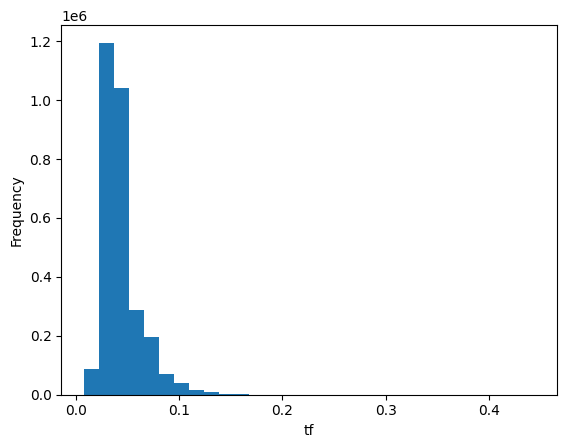

In [99]:
plt.hist(the_fuck_values, bins=30)
plt.xlabel("tf")
plt.ylabel("Frequency")
plt.show()

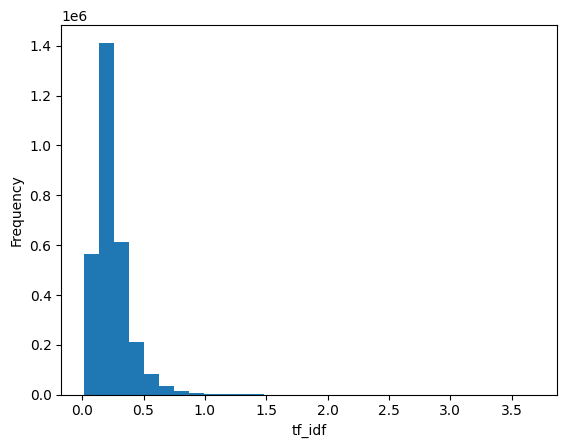

In [100]:
plt.hist(tfidf_values, bins=30)
plt.xlabel("tf_idf")
plt.ylabel("Frequency")
plt.show()

##Part 2 SVM

In [35]:
!curl https://raw.githubusercontent.com/mosesyhc/de300-2025sp-class/refs/heads/main/w.csv -O
!curl https://raw.githubusercontent.com/mosesyhc/de300-2025sp-class/refs/heads/main/bias.csv -O
!curl https://raw.githubusercontent.com/mosesyhc/de300-2025sp-class/refs/heads/main/data_for_svm.csv -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1391  100  1391    0     0   2091      0 --:--:-- --:--:-- --:--:--  2091
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    22  100    22    0     0     43      0 --:--:-- --:--:-- --:--:--    43
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 61.9M  100 61.9M    0     0  14.4M      0  0:00:04  0:00:04 --:--:-- 14.4M


In [ ]:
# This is an example to read the files. But you should consider using pyspark directly.
# *Make sure you are not assuming a header*!!
import pandas as pd
data_svm = pd.read_csv('data_for_svm.csv', header=None)
w = pd.read_csv('w.csv', header=None)
bias = pd.read_csv('bias.csv', header=None)

In [36]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .master("local[*]")
         .appName("SVM")
         .getOrCreate()
        )

data_svm = spark.read.csv("data_for_svm.csv", inferSchema=True, header=False)
w = spark.read.csv("w.csv", inferSchema=True, header=False)
bias = spark.read.csv("bias.csv", inferSchema=True, header=False)


In [37]:
data_svm.show(5)

+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|_c0|_c1|_c2|_c3|_c4|_c5|_c6|_c7|_c8|_c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c30|_c31|_c32|_c33|_c34|_c35|_c36|_c37|_c38|_c39|_c40|_c41|_c42|_c43|_c44|_c45|_c46|_c47|_c48|_c49|_c50|_c51|_c52|_c53|_c54|_c55|_c56|_c57|_c58|_c59|_c60|_c61|_c62|_c63|_c64|
+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
| -1| -1|  1|  1| -1|  1|  1|  1|  1| -1|   1|   

In [38]:
w.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------

In [39]:
bias.show(5)

+--------------------+
|                 _c0|
+--------------------+
|1.495661647902824E-4|
+--------------------+



Find ||w||^2 and 1/n. set lambda and b

In [40]:
w_list = w.collect()[0]
w_list2 = list(w_list)
w_list2
w2 = np.sum(np.array(w_list2))
w2

np.float64(0.0036068090552452414)

In [41]:
n_inv = 1/data_svm.count()
lam = 1
b = bias.collect()[0][0]
b

0.0001495661647902824

map pred or $1 - y_i(w^Tx_i+b)$

In [104]:
# Take each column in data_svm and w. multiple each column together where
# x[last column] * (w[column] * x[row][column] + bias)
def compute_y_pred(row):
  # x[row][all features]
  features = row[:-1]
  # x[last column]
  label = row[-1]
  weights = w_list2
  # sums the features * weights + bias
  z = sum(f * w for f,w in zip(features, weights)) + b
  return row + (z,)

rdd_svm = data_svm.rdd.map(compute_y_pred)

#svm_pred = data_svm.map(compute_y_pred)
#svm_pred.take(5)

In [105]:
# return an rdd with only the last two columns multiplied together
def loss_calc(rdd):
  y_hat = rdd[-1]
  y_pred = rdd[-2]
  return 1 - y_hat * y_pred

preds = rdd_svm.map(loss_calc).sum()
L = lam * w2 + n_inv * preds
L

np.float64(1.0033305714670213)

In [109]:
from pyspark.sql.functions import col

# Get all column names
all_columns = data_svm.columns

# Create the X and y matrix (the features and the label)
X = data_svm.select(*all_columns[:-1])
y = data_svm.select(all_columns[-1])

def loss_SVM(w, b, X, y):
  # This is the same thing as above, gather all the basic numbers (w^2, n^-1, lambda, and bias)
  w_list = w.collect()[0]
  w2 = np.sum(np.array(list(w_list)))
  n_inv = 1/X.count()
  lam = 1
  b = bias.collect()[0][0]

  # Map function for SVM, same as previously
  def compute_y_pred(row):
    features = row[:-1]
    weights = w_list
    z = sum(f * w for f,w in zip(features, weights)) + b
    return row + (z,)

  rdd_svm = X.rdd.map(compute_y_pred)
  # Combine the rdd_svm with the y rdd
  xy_rdd = rdd_svm.zip(y.rdd)

  # Calculate the loss in the SVM
  def loss_calc(rdd):
    svm_row, y_row = rdd
    # prediction (or z) from the previous function
    y_pred = svm_row[-1]
    # y rdd only has one value
    y_hat = y_row[0]
    return max(0,1 - y_hat * y_pred)
  # get the sum of the loss for predictions
  preds = xy_rdd.map(loss_calc).sum()
  # Calculate L(w, b)
  L = lam * w2 + n_inv * preds
  return L
L = loss_SVM(w, b, X, y)
L

np.float64(1.0033288629128445)

In [108]:
from pyspark.sql.functions import col

# This is a replication, the only difference is that I change y_pred to be an integer
def loss_SVM2(w, b, X, y):
  w_list = w.collect()[0]
  w2 = np.sum(np.array(list(w_list)))
  n_inv = 1/X.count()
  lam = 1
  b = bias.collect()[0][0]

  def compute_y_pred(row):
    features = row[:-1]
    label = row[-1]
    weights = w_list2
    z = sum(f * w for f,w in zip(features, weights)) + b
    y_pred = 1 if z > 0 else -1
    return row + (y_pred,)

  rdd_svm = X.rdd.map(compute_y_pred)
  xy_rdd = rdd_svm.zip(y.rdd)

  def loss_calc(rdd):
    svm_row, y_row = rdd
    y_pred = svm_row[-1]
    y_hat = y_row[0]
    return 1 - y_hat * y_pred

  preds = xy_rdd.map(loss_calc).sum()
  L = lam * w2 + n_inv * preds
  return L
L = loss_SVM2(w, b, X, y)
L

np.float64(0.9997318090552453)